## Housekeeping Settings

In [1]:
import numpy as np, pandas as pd, scanpy as sc, anndata as ad, matplotlib.pyplot as plt, os, seaborn as sns
wd = '/ocean/projects/cis240075p/skeshari/igvf/bcell1/male_donor/'
out_path = os.path.join(wd, 'out_data', 'sc_preproc')
os.makedirs(f"{out_path}/figures", exist_ok=True)
os.makedirs(f"{out_path}/out_files", exist_ok=True)
sc.settings.figdir = f"{out_path}/figures"

In [2]:
path_to_adata = os.path.join(wd, 'out_data','out_other_methods/donor1_multiome_gex_post_mira.h5ad')
adata = sc.read_h5ad(path_to_adata)
# #adata to adata1 mapping
# label_mapping_dict = {  
#                         '0':"ActB-1",
#                         '1':"ActB-2",
#                         '2':"ActB-4",
#                         '3':"GC-1",
#                         '4':"ActB-3",
#                         '5': "Naive",
#                         '6':"GC-2",
#                         '7':"PB-2",
#                         '8':"UD",
#                         '9':"earlyPB",
#                         '10':"earlyActB",
#                         '11':"UD_1",
#                     }

# leiden_color_dict = {
#     'ActB-1': 'lightskyblue',     # light blue cluster at bottom
#     'ActB-2': 'dodgerblue',       # darker blue cluster
#     'ActB-4': 'mediumorchid',     # purple cluster
#     'GC-1': 'limegreen',          # bright green cluster
#     'ActB-3': 'darkblue',         # dark blue cluster
#     'Naive': 'darkgray',          # gray cluster on left
#     'GC-2': 'green',              # darker green cluster
#     'PB-2': 'firebrick',          # red cluster
#     'earlyPB': 'lightcoral',      # pink/coral cluster
#     'earlyActB': 'teal',           # teal cluster
#     'UD': 'black',                # black cluster
#     'UD_1': 'black'               # black cluster
# }
# # adata.obs['leiden'] = adata.obs['leiden'].astype(str)
# adata.obs['leiden'] = adata.obs['leiden'].map(label_mapping_dict)
# adata.uns['leiden_colors'] = [leiden_color_dict[i] for i in adata.obs['leiden'].cat.categories.values]
adata

# Data is already normalized and logged.....Since adata.X.A is float, np.sum(adata.X.toarray(), axis=0) in not integers
# Another way to check np.sum(adata.layers['counts'].toarray(), axis=1) is similar to adata.obs["total_counts"]. Also log(1+x) is similar to adata.X
# Layers attribute has the original counts

AnnData object with n_obs × n_vars = 32418 × 23090
    obs: 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11', 'topic_12', 'topic_13', 'topic_14', 'topic_15', 'topic_16', 'topic_17', 'topic_18', 'topic_19', 'topic_20', 'topic_21', 'topic_22', 'topic_23', 'topic_24', 'topic_25', 'topic_26', 'topic_27', 'topic_28', 'topic_29', 'topic_30', 'topic_31', 'leiden', 'score_G1S', 'score_G2M', 'score_myc_up', 'score_GC', 'score_PB', 'score_MBC_1', 'score_MBC_2', 'score_preGC', 'score_LZ_GC', 'score_DZ_GC', 'DNA_damage', 'LZ_vs_DZ_down', 'LZ_vs_DZ_up', 'Ag_presentation', 'BCR_signaling', 'leiden_filtered_cells', 'cell_type_annotation'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'leiden', 'leiden_colors', 'log1p', 'neig

## Scanpy Preprocessing of scRNA
Typical steps which are followed in scRNA processing are:
1.   `Labeling genes which are not required`: Mitochondrial, Ribosomal, Hemoglobin
2.   `Looking for QC of Cells`: Here specifically we want to remove cells which have extremely high mitochondrial count
3.   `Filtering on Genes Expressed`: Getting rid of the genes which we don't want (Mitochondrial, Ribosomal, Hemoglobin)
4.   `Normalizing Gene Counts`: Due to different depth of the cells, we normalize the counts and then lake the log so that the values are in a decent range to be compared
5.   `Feature (here: genes) Selection`: We select top n genes (typically 3k) so that we can run various algorithms downstream. Genes which are specifically of interest should be added back since they might get dropped of due to the "top n genes" filtering
6.   `Dimentionality Reduction`: Not all dimentions (here: genes) are informative. hence run PCA to find the most variable n dimensions.
7.   `Downstream Analysis`: UMAP Plotting, Clustering, Cluster Identification, Expression of certain genes in clusters etc.

### `Labeling genes which are not required`

In [3]:
adata.var["mt"] = adata.var_names.str.startswith("MT-")
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")
adata.var["linc"] = adata.var_names.str.contains("LINC")

### `Looking for QC of Cells`

Number of cells before filtering of low quality cells: 32418


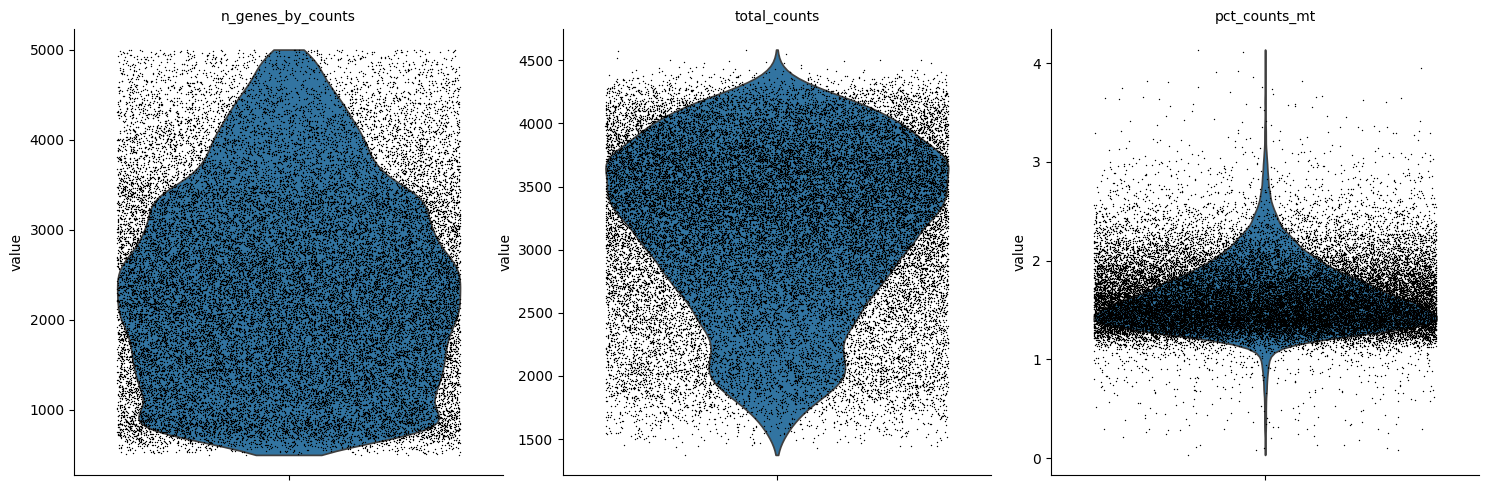

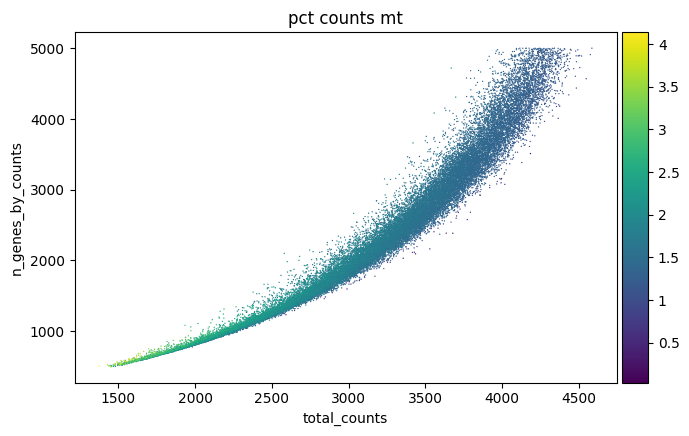

In [4]:
print(f"Number of cells before filtering of low quality cells: {adata.n_obs}")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True)
# the number of genes expressed in the count matrix, the total counts per cell, and the percentage of counts in mitochondrial genes
sc.pl.violin(adata,["n_genes_by_counts", "total_counts", "pct_counts_mt"],jitter=0.4,multi_panel=True, save="_qc_metrics_violin.png")
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt", save="_qc_metrics_scatter.png")

### `Cleaning up cells which are not needed/ low QC`
Removing outliers : MAD (median absolute deviations)

In [5]:
# # NOT running since data is already cleaned
# def is_outlier(adata, metric: str, nmads: int):
#     M = adata.obs[metric]
#     median_abs_deviation = np.median(np.abs(M - np.median(M)))
#     outlier = (M < np.median(M) - nmads * median_abs_deviation) | (np.median(M) + nmads * median_abs_deviation < M)
#     return outlier

# adata.obs["outlier"] = (is_outlier(adata, "log1p_total_counts", 5) | is_outlier(adata, "log1p_n_genes_by_counts", 5) | is_outlier(adata, "pct_counts_in_top_50_genes", 5))
# adata.obs["mt_outlier"] = is_outlier(adata, "pct_counts_mt", 3) | (adata.obs["pct_counts_mt"] > 8)
# adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()

### `Filtering on Genes Expressed`

In [5]:
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)
adata = adata[:, (~adata.var['mt'] & ~adata.var['ribo'] & ~adata.var['hb'] & ~adata.var['linc'])] # Filter mitochondrial, linc, ribosomal, haemoglobin genes

#### Checking post QC

Number of cells after filtering of low quality cells: 32418


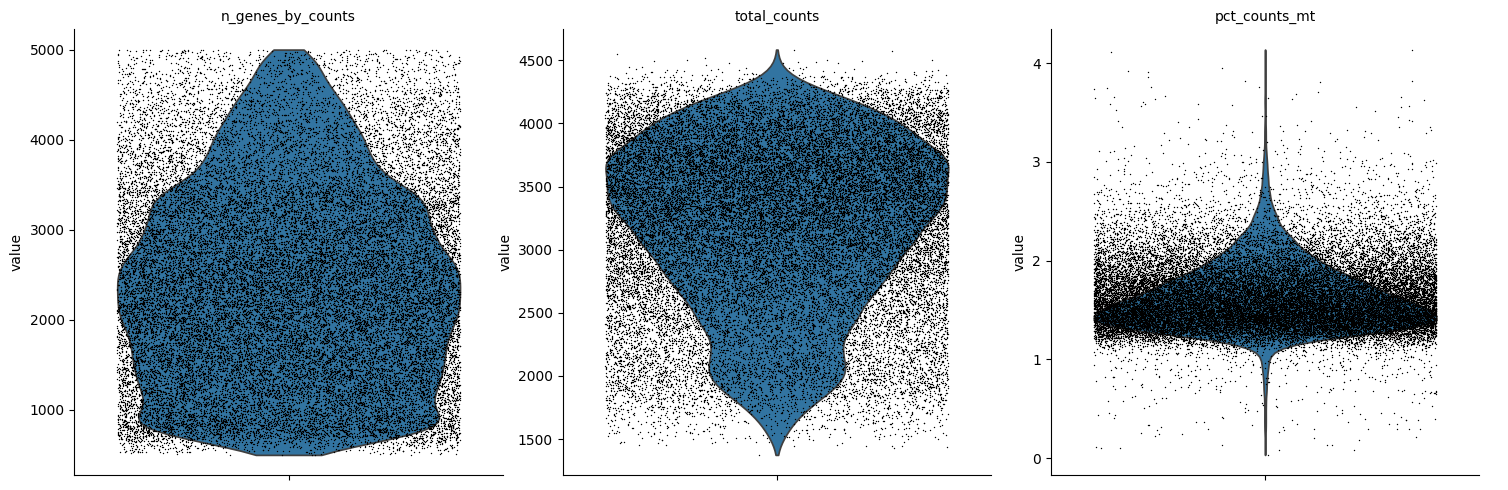

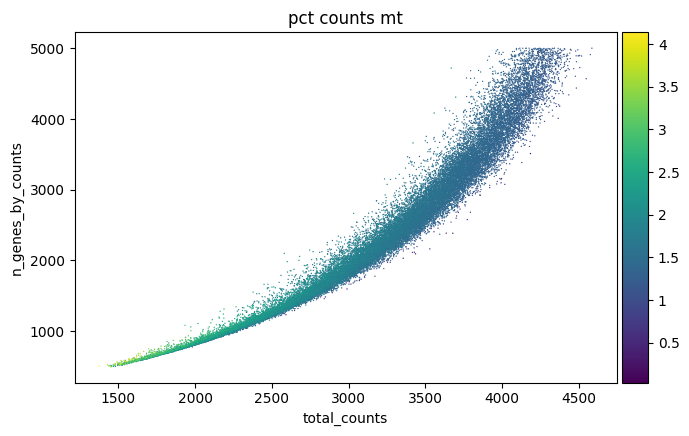

In [6]:
print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")
# the number of genes expressed in the count matrix, the total counts per cell, and the percentage of counts in mitochondrial genes
sc.pl.violin(adata,["n_genes_by_counts", "total_counts", "pct_counts_mt"],jitter=0.4,multi_panel=True, save="_qc_metrics_violin_filtered.png")
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt", save="_qc_metrics_scatter_filtered.png")

### `Normalizing Gene Counts`

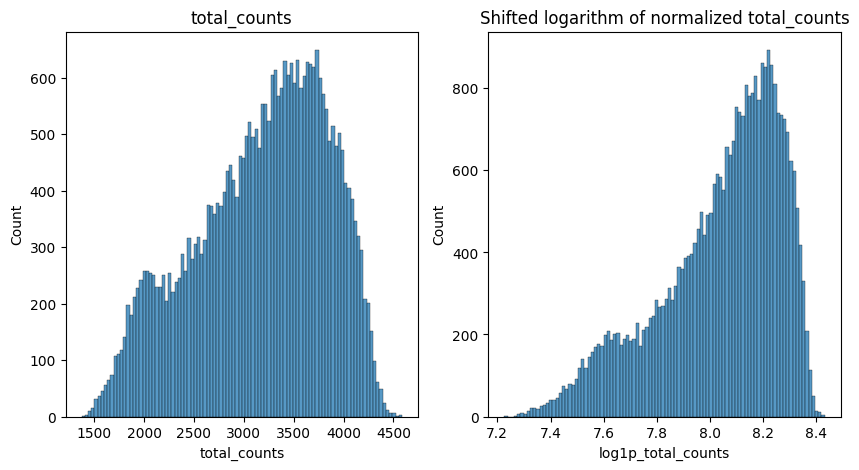

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("total_counts")
adata.layers["counts"] = adata.X.copy() # Saving the actual counts in different layer. often not useful due to variability in sequencing depth and other technical biases.
sc.pp.normalize_per_cell(adata, key_n_counts='total_counts') # Normalizing to median total counts
sc.pp.log1p(adata) # Taking log of the values
sns.histplot(adata.obs["log1p_total_counts"], bins=100, kde=False, ax=axes[1])
axes[1].set_title("Shifted logarithm of normalized total_counts")
adata.raw = adata # store the log normalized data
plt.savefig(os.path.join(sc.settings.figdir, "total_counts.png"))

### `Feature (here: genes) Selection`
#### We use MIRA hvgs + TFs perturbed

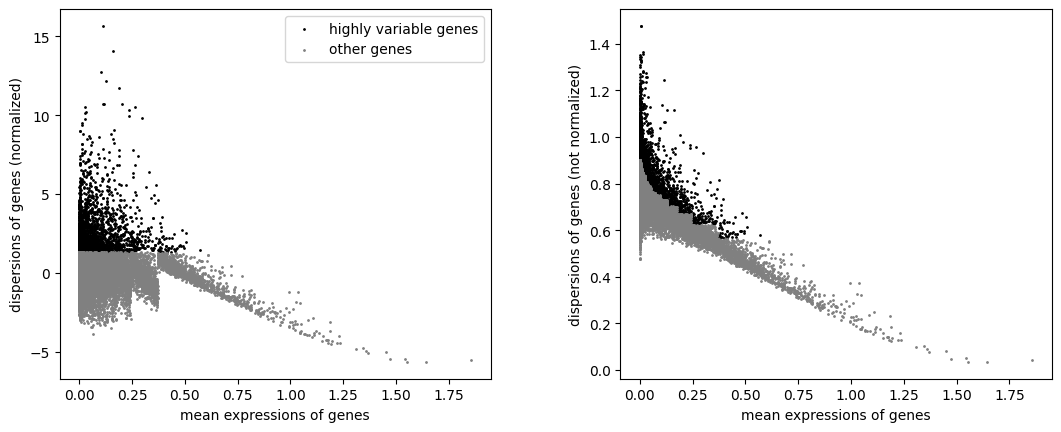

In [8]:
sc.pp.highly_variable_genes(adata,flavor='cell_ranger',n_top_genes=3000)
sc.pl.highly_variable_genes(adata, save="_highly_variable_genes.png")

In [9]:
# We use MIRA hvgs + TF in perturbations
mira_grn = pd.read_csv(f'{wd}/out_data/out_other_methods/ISD/ISD_matrix.chip.tsv', sep='\t',header = 0, low_memory=False, index_col=0)
hvf_genes_mira = set(mira_grn.index)
tf_perturb_list = set([ "BATF","BATF3","BCL6","EGR1","FOS","IKZF1","IRF1","IRF4","IRF8","JUNB","JUND","MEF2A","MEF2C",\
                        "MYB","NFATC1","NTC1","NFATC2","NFIL3","NFKB1","NFKB2","PAX5","PRDM1","RUNX1","SP3","SPI1","STAT1",\
                        "STAT5A","TCF12","VDR","XBP1","ZBTB7A","SPIB"])  # Experimentally perturbed TFs

genes_of_interest = hvf_genes_mira.union(tf_perturb_list)

In [10]:
for gene in adata.var.index:
    if gene not in genes_of_interest:
        adata.var.loc[gene, 'highly_variable'] = False
    else:
        adata.var.loc[gene, 'highly_variable'] = True

In [11]:
# adata = adata[:, adata.var_names.isin(genes_of_interest)]
sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"])
sc.pp.scale(adata, max_value=10)

### `Dimentionality Reduction`

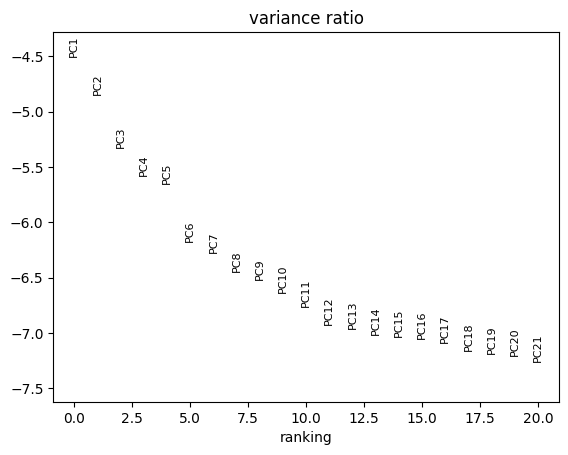

In [12]:
sc.tl.pca(adata)
sc.pl.pca_variance_ratio(adata, n_pcs=20, log=True)
sc.pp.neighbors(adata)

### `Downstream Analysis`

#### Cluster and Plot in reduced dimensions

/ocean/projects/cis240075p/skeshari/.conda/envs/celloracle_env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/ocean/projects/cis240075p/skeshari/.conda/envs/celloracle_env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


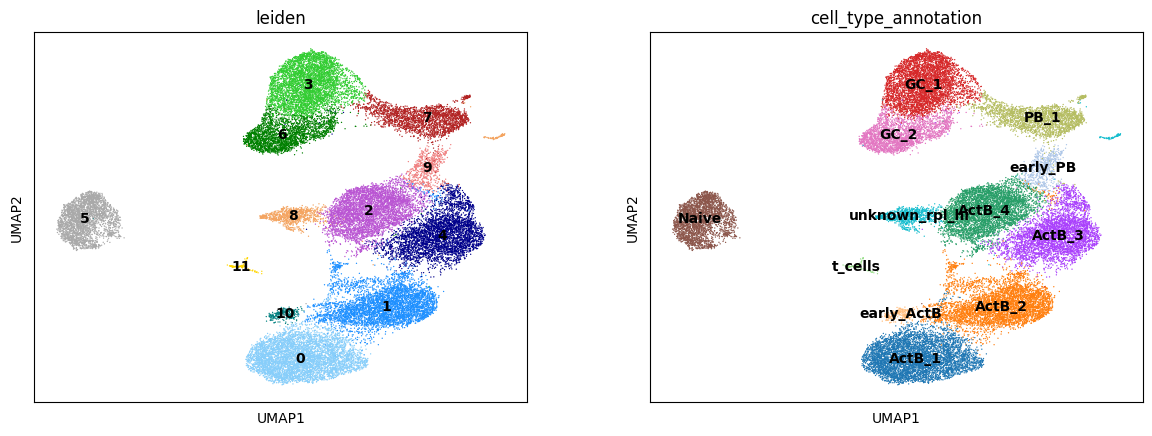

In [16]:
# Already clustered anndata
# sc.tl.umap(adata, random_state=42, min_dist=1, spread=1)
# sc.tl.leiden(adata, key_added=f"leiden", resolution=0.50)
sc.pl.umap(adata, color=["leiden", "cell_type_annotation"], legend_loc="on data", save="_leiden_umap.png")

#### Save anndata

In [17]:
adata.write(f'{out_path}/out_files/male_sc_processed.h5ad')